In [1]:
import torch
print(torch.__version__)

2.0.1+cu118


In [2]:
import pandas as pd
import numpy as np
import random
import spacy
import matplotlib as plt
import warnings
warnings.simplefilter("ignore")
SEED = 32
torch.manual_seed(SEED)


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
df = pd.read_csv('/content/drive/MyDrive/Semester Final/sc project/bragging_data.csv')
df.head(2)

,id,text,sampling,round,label
0,1142887970506268676,Do n't think I 'm gonna get around to uploadin...,random,1,not
1,1100041263540260864,girls are gonna rt this in hopes that their sh...,random,1,not


In [5]:
df=df.drop(["id","sampling","round"],axis=1)
df.head(3)

,text,label
0,Do n't think I 'm gonna get around to uploadin...,not
1,girls are gonna rt this in hopes that their sh...,not
2,I remember those days ?,not


In [6]:
df.shape

(6696, 2)

In [7]:
df["label"].unique()

array(['not', 'achievement', 'action', 'possession', 'trait',
       'affiliation', 'feeling'], dtype=object)

In [8]:
df["label"].value_counts()

not            5915
achievement     237
action          185
trait           139
possession       86
affiliation      68
feeling          66
Name: label, dtype: int64

In [9]:
def binary_class_dataset(data):

    data = data.iloc[:, [0, 1]]
    data.columns = ['text', 'label']
    Original_labels = {
        'not':0,                         #0-> not self boasting
        'achievement':1,                 #1-> self boasting
        'action':1,
        'possession':1,
        'trait':1,
        'affiliation':1,
        'feeling':1
    }
    data['label'] = data['label'].map(Original_labels)

    return data

In [10]:
binary_df= binary_class_dataset(df)
binary_df.tail(5)

,text,label
6691,my cat is really dumb . he deserves a kiss on ...,1
6692,David de Gea racks up his 100th Premier League...,0
6693,@USER Just to show the versatility :face_with_...,0
6694,#humblebrag - - 1 of our hundreds of 5 - star ...,0
6695,"Mizzou gets a callahan , tied 2-2 !",0


In [11]:
binary_df["label"].value_counts()

0    5915
1     781
Name: label, dtype: int64

In [12]:
len(binary_df)

6696

In [13]:
binary_df.isnull().sum()

text     0
label    0
dtype: int64

In [ ]:
# pip install nlpaug

In [ ]:
# pip install nltk

In [14]:
final_df=binary_df.copy()
final_df.head(5)

,text,label
0,Do n't think I 'm gonna get around to uploadin...,0
1,girls are gonna rt this in hopes that their sh...,0
2,I remember those days ?,0
3,ms . corona is just rude . i wo n't be able to...,0
4,ok i 'm gonna go watch maleficent hype me up i...,0


In [15]:
%pip install torchvision

In [16]:
pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 18.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 28.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 65.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 68.7 MB/s eta 0:00:00


In [17]:
import re
import string
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from transformers import AutoModel
from transformers import BertModel, BertTokenizer
from transformers import DistilBertTokenizer, DistilBertModel
from transformers import RobertaTokenizer, RobertaModel

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

In [18]:
torch.cuda.is_available()

True

In [19]:
emoticon_to_word = {
    ":)": "happy",
    ":D": "laugh",
    ":(": "sad",
    ":P": "playful",
    ";)": "wink",
    "<3": "heart",
    ":|": "neutral",
    ":O": "surprised",
    ":/": "confused",
    ":*": "kiss",
    ":3": "cute",
    ":')": "tears of joy",
    ":$": "blush",
    ":]": "smile",
    ":>": "smirk",
    ":<": "disappointed",
    ":o)": "clown",
    ":-(": "frown",
    ":O)": "angelic",
    ":'(": "cry",
    ":v": "peace",
    ":]": "glasses",
    "8-)": "cool",
    ">:(": "angry",
    ":X": "zip_it",
    ":'D": "rofl",
    ":-O": "shocked",
    ":|]": "robot",
    "<(\" )": "penguin",
    "^_^": "kawaii",
    ">_>": "shifty eyes",
    "O:)": "halo",
    ":-*": "blow kiss",
    "8-D": "big laugh",
    ":no_mouth:": "speechless",
    '(-:':'Frown, sad, angry or pouting',
    ':-)))':'Very very Happy face or smiley',
    'XD':'Laughing, big grin or laugh with glasses',
    'xd':'Laughing, big grin or laugh with glasses',
    ":thumbs_up:": "thumbs up",
    ":red_heart:":"red heart",
    ":smiling_face_with_heart-eyes:" : "smiling face with heart-eyes ",
    ":hugging_face:":"hugging_face",
    " :beaming_face_with_smiling_eyes:" : " beaming_face_with_smiling_eyes",
    " :double_exclamation_mark:":" double_exclamation_mark",
    ":clapping_hands: ":"clapping_hands"
}


In [20]:
def replace_emoticons(text, emoticon_to_word):
    for emoticon, word in emoticon_to_word.items():
        text = text.replace(emoticon, word)
    return text


final_df['text'] = final_df['text'].apply(lambda text: replace_emoticons(text, emoticon_to_word))


In [21]:
test_text = replace_emoticons(final_df['text'][964], emoticon_to_word)
print(test_text)

i 'm gonna hit 1k by the end of next month i feel it happy


In [ ]:
final_df.head(10)

,text,label
0,Do n't think I 'm gonna get around to uploadin...,0
1,girls are gonna rt this in hopes that their sh...,0
2,I remember those days ?,0
3,ms . corona is just rude . i wo n't be able to...,0
4,ok i 'm gonna go watch maleficent hype me up i...,0
5,THIS is the only good cop in this day and age .,0
6,"even a small clip like this , I can laugh out ...",0
7,@USER @USER lmfaoooo ! i 'll never be a shirt ...,0
8,PSPC 's Translation Bureau - we do that ! thum...,0
9,wait theyre gonna post mark and haechan oh my god,0


In [22]:
print(len(final_df))

6696


In [23]:
final_df['text'].str.split().apply(len).max()

107

In [66]:
train_df, temp_df = train_test_split(final_df, test_size=0.3, random_state=42,stratify=final_df['label'])
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42,stratify=temp_df['label'])

In [67]:
train_df['label'].value_counts()

0    4140
1     547
Name: label, dtype: int64

In [80]:
val_df['label'].value_counts()

0    887
1    117
Name: label, dtype: int64

In [81]:
test_df['label'].value_counts()

0    888
1    117
Name: label, dtype: int64

In [25]:
pip install nlpaug

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.5/410.5 kB 3.2 MB/s eta 0:00:00


In [49]:
# from nlpaug.augmenter.word import SynonymAug

# bragging_data = train_df[train_df['label'] == 1]
# not_bragging_data = train_df[train_df['label'] == 0]

# aug_synonym = SynonymAug(aug_src='wordnet')
# augmented_bragging_data = []

# for text in bragging_data['text']:
#     augmented_text = aug_synonym.augment(text)
#     augmented_bragging_data.append({'text': augmented_text, 'label': 1})

# augmented_bragging_df = pd.DataFrame(augmented_bragging_data)

# balanced_train_df = pd.concat([not_bragging_data, augmented_bragging_df], ignore_index=True)

In [125]:
pip install transformers


In [127]:
pip install sentencepiece


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 7.8 MB/s eta 0:00:00


In [151]:
import pandas as pd
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler

X = train_df['text']
y = train_df['label']

oversampler = RandomOverSampler(sampling_strategy='minority', random_state=42)
X_train_resampled, y_train_resampled = oversampler.fit_resample(X.values.reshape(-1, 1), y)

# Convert the resampled data back to a DataFrame
balanced_train_df = pd.DataFrame({'text': X_train_resampled.ravel(), 'label': y_train_resampled})
balanced_train_df = balanced_train_df.sample(frac=1).reset_index(drop=True)


In [ ]:
# import pandas as pd
# import nlpaug.augmenter.word as naw
# from sklearn.model_selection import train_test_split

# X = train_df['text']
# y = train_df['label']


# augmenter = naw.ContextualWordEmbsAug(
#     model_path='bert-base-uncased', action="insert", aug_max=10
# )

# augmented_data = []
# for text, label in zip(X, y):
#     if label == 1:
#         augmented_text = augmenter.augment(text)
#         augmented_data.append({'text': augmented_text, 'label': label})


# augmented_df = pd.DataFrame(augmented_data)

# balanced_train_df = pd.concat([X.to_frame(), augmented_df['text']], axis=1)
# balanced_train_df['label'] = y
# balanced_train_df = balanced_train_df.sample(frac=1).reset_index(drop=True)


In [152]:
print(len(balanced_train_df))

8280


In [153]:
print(balanced_train_df['label'].value_counts())

0    4140
1    4140
Name: label, dtype: int64


In [154]:
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
distilbert_tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
roberta_tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

In [155]:
max_length = 128

def tokenize_data(data_df, tokenizer, max_length):
    input_ids = []
    attention_masks = []
    labels = []

    for text, label in data_df[['text', 'label']].values:
        encoded = tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])
        labels.append(label)

    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)
    labels = torch.tensor(labels)

    return input_ids, attention_masks, labels

In [156]:
# Tokenize using BERT tokenizer
max_length = 128
train_input_ids_bert, train_attention_masks_bert, train_labels_bert = tokenize_data(balanced_train_df,bert_tokenizer, max_length)
val_input_ids_bert, val_attention_masks_bert, val_labels_bert = tokenize_data(val_df,bert_tokenizer, max_length)
test_input_ids_bert, test_attention_masks_bert, test_labels_bert = tokenize_data(test_df,bert_tokenizer, max_length)

# Tokenize using DistilBERT tokenizer
train_input_ids_distilbert, train_attention_masks_distilbert, train_labels_distilbert = tokenize_data(balanced_train_df,distilbert_tokenizer, max_length)
val_input_ids_distilbert, val_attention_masks_distilbert, val_labels_distilbert = tokenize_data(val_df,distilbert_tokenizer, max_length)
test_input_ids_distilbert, test_attention_masks_distilbert, test_labels_distilbert = tokenize_data(test_df,distilbert_tokenizer, max_length)

# Tokenize using RoBERTa tokenizer
train_input_ids_roberta, train_attention_masks_roberta, train_labels_roberta = tokenize_data(balanced_train_df,roberta_tokenizer, max_length)
val_input_ids_roberta, val_attention_masks_roberta, val_labels_roberta = tokenize_data(val_df,roberta_tokenizer, max_length)
test_input_ids_roberta, test_attention_masks_roberta, test_labels_roberta = tokenize_data(test_df,roberta_tokenizer, max_length)

In [157]:
train_dataset_bert = TensorDataset(train_input_ids_bert, train_attention_masks_bert, train_labels_bert)
val_dataset_bert = TensorDataset(val_input_ids_bert, val_attention_masks_bert, val_labels_bert)
test_dataset_bert = TensorDataset(test_input_ids_bert, test_attention_masks_bert, test_labels_bert)

train_dataset_distilbert = TensorDataset(train_input_ids_distilbert, train_attention_masks_distilbert, train_labels_distilbert)
val_dataset_distilbert = TensorDataset(val_input_ids_distilbert, val_attention_masks_distilbert, val_labels_distilbert)
test_dataset_distilbert = TensorDataset(test_input_ids_distilbert, test_attention_masks_distilbert, test_labels_distilbert)

train_dataset_roberta = TensorDataset(train_input_ids_roberta, train_attention_masks_roberta, train_labels_roberta)
val_dataset_roberta = TensorDataset(val_input_ids_roberta, val_attention_masks_roberta, val_labels_roberta)
test_dataset_roberta = TensorDataset(test_input_ids_roberta, test_attention_masks_roberta, test_labels_roberta)

In [158]:
print(len(train_dataset_bert))

8280


In [182]:
batch_size = 32
num_epochs = 5
learning_rate =0.0001

train_dataloader_bert = DataLoader(train_dataset_bert, batch_size=batch_size, shuffle=True)
val_dataloader_bert = DataLoader(val_dataset_bert, batch_size=batch_size, shuffle=False)
test_dataloader_bert = DataLoader(test_dataset_bert, batch_size=batch_size, shuffle=False)

train_dataloader_distilbert = DataLoader(train_dataset_distilbert, batch_size=batch_size, shuffle=True)
val_dataloader_distilbert = DataLoader(val_dataset_distilbert, batch_size=batch_size, shuffle=False)
test_dataloader_distilbert = DataLoader(test_dataset_distilbert, batch_size=batch_size, shuffle=False)

train_dataloader_roberta = DataLoader(train_dataset_roberta, batch_size=batch_size, shuffle=True)
val_dataloader_roberta = DataLoader(val_dataset_roberta, batch_size=batch_size, shuffle=False)
test_dataloader_roberta = DataLoader(test_dataset_roberta, batch_size=batch_size, shuffle=False)

In [183]:
from transformers import BertForSequenceClassification, DistilBertForSequenceClassification, RobertaForSequenceClassification, AdamW

bert_model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)
distilbert_model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2)
roberta_model = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=2)

bert_model.to(device)
distilbert_model.to(device)
roberta_model.to(device)


criterion = nn.CrossEntropyLoss()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'classifier.bias', 'pre_classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.out_proj.weight', 'classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and infe

In [184]:
bert_optimizer = AdamW(bert_model.parameters(), lr=learning_rate)
distilbert_optimizer = AdamW(distilbert_model.parameters(), lr=learning_rate)
roberta_optimizer = AdamW(roberta_model.parameters(), lr=learning_rate)

FOR BERT

In [185]:
validation_losses = []
validation_accuracies = []
bert_model.train()

for epoch in range(num_epochs):
    total_loss = 0

    for batch in train_dataloader_bert:
        input_ids, attention_masks, labels = batch
        input_ids = input_ids.to(device)
        attention_masks = attention_masks.to(device)
        labels = labels.to(device)

        bert_optimizer.zero_grad()
        outputs = bert_model(input_ids, attention_mask=attention_masks)[0]
        loss = criterion(outputs, labels)
        loss.backward()
        bert_optimizer.step()
        total_loss += loss.item()

    average_loss = total_loss / len(train_dataloader_bert)
    print(f"BERT Epoch {epoch+1}/{num_epochs} - Average Loss: {average_loss:.4f}")

    bert_model.eval()
    val_loss = 0
    val_accuracy = 0
    val_total = 0

    with torch.no_grad():
        for batch in val_dataloader_bert:
            inputs, masks, labels = batch
            inputs = inputs.to(device)
            masks = masks.to(device)
            labels = labels.to(device)

            outputs = bert_model(inputs, attention_mask=masks)[0]
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs, dim=1)
            val_accuracy += (predicted == labels).sum().item()
            val_total += len(labels)

    average_val_loss = val_loss / len(val_dataloader_bert)
    accuracy = val_accuracy / val_total

    validation_losses.append(average_val_loss)
    validation_accuracies.append(accuracy)

    print(f"BERT Validation Loss: {average_val_loss:.4f} - BERT Validation Accuracy: {accuracy:.2f}")

BERT Epoch 1/5 - Average Loss: 0.3280
BERT Validation Loss: 0.3665 - BERT Validation Accuracy: 0.88
BERT Epoch 2/5 - Average Loss: 0.0475
BERT Validation Loss: 0.5256 - BERT Validation Accuracy: 0.90
BERT Epoch 3/5 - Average Loss: 0.0172
BERT Validation Loss: 0.5837 - BERT Validation Accuracy: 0.90
BERT Epoch 4/5 - Average Loss: 0.0277
BERT Validation Loss: 0.4458 - BERT Validation Accuracy: 0.91
BERT Epoch 5/5 - Average Loss: 0.0266
BERT Validation Loss: 0.5367 - BERT Validation Accuracy: 0.90


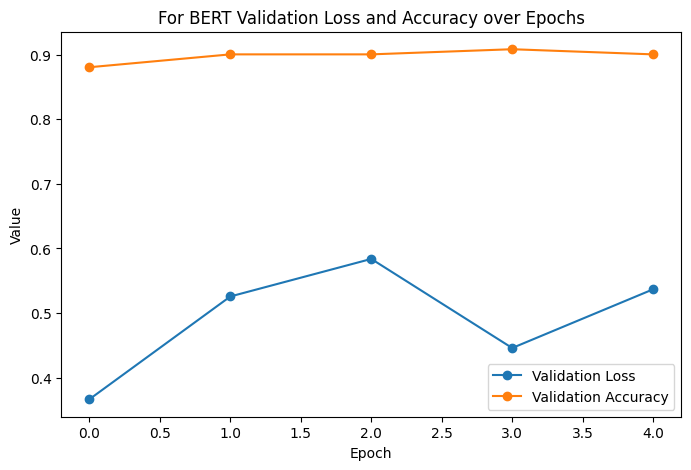

In [186]:
import matplotlib.pyplot as plt

# Plotting the graph
plt.figure(figsize=(8, 5))
plt.plot(validation_losses, label='Validation Loss', marker='o')
plt.plot(validation_accuracies, label='Validation Accuracy', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.title('For BERT Validation Loss and Accuracy over Epochs')
plt.legend()
plt.show()

In [187]:
# Evaluation on test set
test_loss = 0
test_accuracy = 0
test_total = 0
all_labels = []
all_predicted = []

with torch.no_grad():
    for batch in test_dataloader_bert:
        inputs, masks, labels = batch
        inputs = inputs.to(device)
        masks = masks.to(device)
        labels = labels.to(device)

        outputs = bert_model(inputs, attention_mask=masks)[0]
        loss = criterion(outputs, labels)
        test_loss += loss.item()

        _, predicted = torch.max(outputs, dim=1)
        test_accuracy += (predicted == labels).sum().item()
        test_total += len(labels)

        all_labels.extend(labels.cpu().numpy())
        all_predicted.extend(predicted.cpu().numpy())

average_test_loss = test_loss / len(test_dataloader_bert)
accuracy = test_accuracy / test_total
print(f"Test Loss: {average_test_loss:.4f} - Test Accuracy: {accuracy:.4f}")

Test Loss: 0.4713 - Test Accuracy: 0.9065


In [188]:
from sklearn.metrics import confusion_matrix
bert_confusion = confusion_matrix(all_labels, all_predicted)
print("Confusion Matrix:")
print(bert_confusion)

Confusion Matrix:
[[875  13]
 [ 81  36]]


In [189]:
target_names = ['Not Bragging', 'Bragging']
classification_rep = classification_report(all_labels, all_predicted,target_names=target_names)
print("Classification Report:")
print(classification_rep)

Classification Report:
              precision    recall  f1-score   support

Not Bragging       0.92      0.99      0.95       888
    Bragging       0.73      0.31      0.43       117

    accuracy                           0.91      1005
   macro avg       0.82      0.65      0.69      1005
weighted avg       0.89      0.91      0.89      1005



In [190]:
def predict_bragging(text, model):
    # Tokenize and preprocess input text
    inputs = bert_tokenizer.encode_plus(text, add_special_tokens=True, padding='max_length', max_length=128, return_tensors='pt')
    input_ids = inputs['input_ids']
    attention_mask = inputs['attention_mask']

    # Move tensors to the same device as the model
    input_ids = input_ids.to(device)
    attention_mask = attention_mask.to(device)

    # Make prediction
    with torch.no_grad():
        model.eval()

        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits  # Access the logits directly
        predictions = logits.argmax(dim=1)  # Get the index of the highest logit as prediction

    # Convert tensor to numpy array
    predictions = predictions.cpu().numpy()

    for prediction in predictions:
        probability = torch.sigmoid(logits).cpu().numpy()  # Calculate probability
        probability = probability[0][1]  # Extract probability for positive class

        if probability > 0.50:
            print(f'{probability:.3f}: Bragging')
        else:
            print(f'{probability:.3f}: Not bragging')

    return predictions

# Example usage
test_text = "Do n't think I 'm gonna get around to uploading an episode tonight - listen to The Night Train instead , it 's better xx"
prediction = predict_bragging(test_text, bert_model)


0.019: Not bragging


FOR DISTILBERT

In [191]:
validation_losses_distilbert = []
validation_accuracies_distilbert = []
distilbert_model.train()

for epoch in range(num_epochs):
    total_loss = 0

    for batch in train_dataloader_distilbert:
        input_ids, attention_masks, labels = batch
        input_ids = input_ids.to(device)
        attention_masks = attention_masks.to(device)
        labels = labels.to(device)

        distilbert_optimizer.zero_grad()
        outputs = distilbert_model(input_ids, attention_mask=attention_masks)[0]
        loss = criterion(outputs, labels)
        loss.backward()
        distilbert_optimizer.step()
        total_loss += loss.item()

    average_loss = total_loss / len(train_dataloader_distilbert)
    print(f"DistilBERT Epoch {epoch+1}/{num_epochs} - Average Loss: {average_loss:.4f}")

    distilbert_model.eval()
    val_loss = 0
    val_accuracy = 0
    val_total = 0

    with torch.no_grad():
        for batch in val_dataloader_distilbert:
            inputs, masks, labels = batch
            inputs = inputs.to(device)
            masks = masks.to(device)
            labels = labels.to(device)

            outputs = distilbert_model(inputs, attention_mask=masks)[0]
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs, dim=1)
            val_accuracy += (predicted == labels).sum().item()
            val_total += len(labels)

    average_val_loss = val_loss / len(val_dataloader_distilbert)
    accuracy = val_accuracy / val_total

    validation_losses_distilbert.append(average_val_loss)
    validation_accuracies_distilbert.append(accuracy)

    print(f"DistilBERT Validation Loss: {average_val_loss:.4f} - DistilBERT Validation Accuracy: {accuracy:.2f}")


DistilBERT Epoch 1/5 - Average Loss: 0.2808
DistilBERT Validation Loss: 0.3598 - DistilBERT Validation Accuracy: 0.89
DistilBERT Epoch 2/5 - Average Loss: 0.0404
DistilBERT Validation Loss: 0.5654 - DistilBERT Validation Accuracy: 0.89
DistilBERT Epoch 3/5 - Average Loss: 0.0192
DistilBERT Validation Loss: 0.4965 - DistilBERT Validation Accuracy: 0.88
DistilBERT Epoch 4/5 - Average Loss: 0.0097
DistilBERT Validation Loss: 0.7636 - DistilBERT Validation Accuracy: 0.86
DistilBERT Epoch 5/5 - Average Loss: 0.0205
DistilBERT Validation Loss: 0.5764 - DistilBERT Validation Accuracy: 0.89


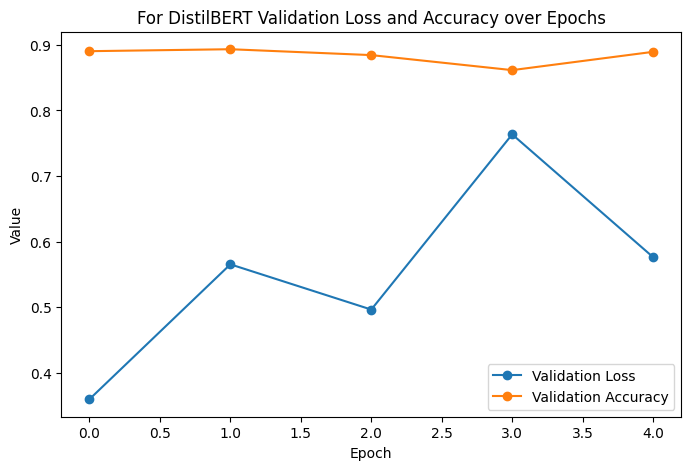

In [192]:
# Plotting the graph
plt.figure(figsize=(8, 5))
plt.plot(validation_losses_distilbert, label='Validation Loss', marker='o')
plt.plot(validation_accuracies_distilbert, label='Validation Accuracy', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.title('For DistilBERT Validation Loss and Accuracy over Epochs')
plt.legend()
plt.show()

In [193]:
test_loss_distilbert = 0
test_accuracy_distilbert = 0
test_total_distilbert = 0
all_labels_distilbert = []
all_predicted_distilbert = []

with torch.no_grad():
    for batch in test_dataloader_distilbert:
        inputs, masks, labels = batch
        inputs = inputs.to(device)
        masks = masks.to(device)
        labels = labels.to(device)

        outputs = distilbert_model(inputs, attention_mask=masks)[0]
        loss = criterion(outputs, labels)
        test_loss_distilbert += loss.item()

        _, predicted = torch.max(outputs, dim=1)
        test_accuracy_distilbert += (predicted == labels).sum().item()
        test_total_distilbert += len(labels)

        all_labels_distilbert.extend(labels.cpu().numpy())
        all_predicted_distilbert.extend(predicted.cpu().numpy())

average_test_loss_distilbert = test_loss_distilbert / len(test_dataloader_distilbert)
accuracy_distilbert = test_accuracy_distilbert / test_total_distilbert
print(f"DistilBERT Test Loss: {average_test_loss_distilbert:.4f} - DistilBERT Test Accuracy: {accuracy_distilbert:.4f}")


DistilBERT Test Loss: 0.5196 - DistilBERT Test Accuracy: 0.9005


In [194]:
from sklearn.metrics import confusion_matrix
distilbert_confusion = confusion_matrix(all_labels_distilbert, all_predicted_distilbert)
print("Confusion Matrix:")
print(distilbert_confusion)

Confusion Matrix:
[[874  14]
 [ 86  31]]


In [195]:
target_names = ['Not Bragging', 'Bragging']
distilbert_classification_rep = classification_report(all_labels_distilbert, all_predicted_distilbert)
print("Classification Report:")
print(distilbert_classification_rep)

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.98      0.95       888
           1       0.69      0.26      0.38       117

    accuracy                           0.90      1005
   macro avg       0.80      0.62      0.66      1005
weighted avg       0.88      0.90      0.88      1005



FOR ROBERTa

In [196]:
validation_losses_roberta = []
validation_accuracies_roberta = []
roberta_model.train()

for epoch in range(num_epochs):
    total_loss = 0

    for batch in train_dataloader_roberta:
        input_ids, attention_masks, labels = batch
        input_ids = input_ids.to(device)
        attention_masks = attention_masks.to(device)
        labels = labels.to(device)

        roberta_optimizer.zero_grad()
        outputs = roberta_model(input_ids, attention_mask=attention_masks)[0]
        loss = criterion(outputs, labels)
        loss.backward()
        roberta_optimizer.step()
        total_loss += loss.item()

    average_loss = total_loss / len(train_dataloader_roberta)
    print(f"RoBERTa Epoch {epoch+1}/{num_epochs} - Average Loss: {average_loss:.4f}")

    roberta_model.eval()
    val_loss = 0
    val_accuracy = 0
    val_total = 0

    with torch.no_grad():
        for batch in val_dataloader_roberta:
            inputs, masks, labels = batch
            inputs = inputs.to(device)
            masks = masks.to(device)
            labels = labels.to(device)

            outputs = roberta_model(inputs, attention_mask=masks)[0]
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs, dim=1)
            val_accuracy += (predicted == labels).sum().item()
            val_total += len(labels)

    average_val_loss = val_loss / len(val_dataloader_roberta)
    accuracy = val_accuracy / val_total

    validation_losses_roberta.append(average_val_loss)
    validation_accuracies_roberta.append(accuracy)

    print(f"RoBERTa Validation Loss: {average_val_loss:.4f} - RoBERTa Validation Accuracy: {accuracy:.2f}")


RoBERTa Epoch 1/5 - Average Loss: 0.4190
RoBERTa Validation Loss: 0.3696 - RoBERTa Validation Accuracy: 0.87
RoBERTa Epoch 2/5 - Average Loss: 0.1242
RoBERTa Validation Loss: 0.3712 - RoBERTa Validation Accuracy: 0.89
RoBERTa Epoch 3/5 - Average Loss: 0.0614
RoBERTa Validation Loss: 0.3735 - RoBERTa Validation Accuracy: 0.85
RoBERTa Epoch 4/5 - Average Loss: 0.0557
RoBERTa Validation Loss: 0.4224 - RoBERTa Validation Accuracy: 0.89
RoBERTa Epoch 5/5 - Average Loss: 0.1276
RoBERTa Validation Loss: 0.4680 - RoBERTa Validation Accuracy: 0.90


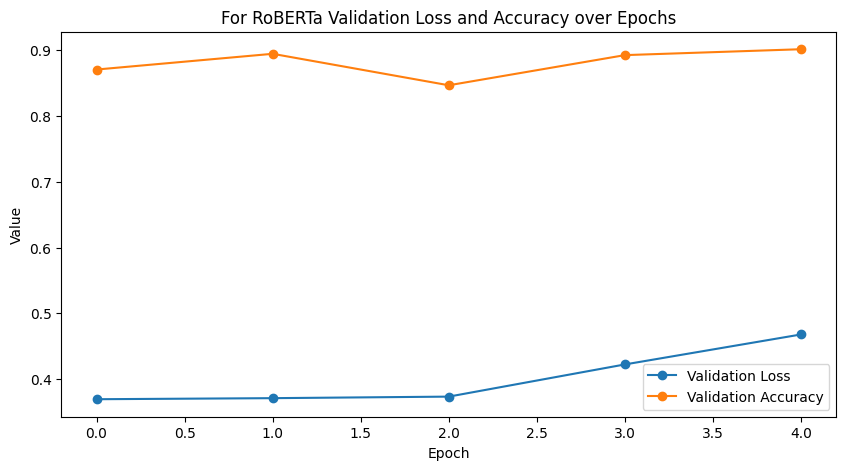

In [197]:
plt.figure(figsize=(10, 5))
plt.plot(validation_losses_roberta, label='Validation Loss', marker='o')
plt.plot(validation_accuracies_roberta, label='Validation Accuracy', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.title('For RoBERTa Validation Loss and Accuracy over Epochs')
plt.legend()
plt.show()

In [198]:
test_loss_roberta = 0
test_accuracy_roberta = 0
test_total_roberta = 0
all_labels_roberta = []
all_predicted_roberta = []

with torch.no_grad():
    for batch in test_dataloader_roberta:
        inputs, masks, labels = batch
        inputs = inputs.to(device)
        masks = masks.to(device)
        labels = labels.to(device)

        outputs = roberta_model(inputs, attention_mask=masks)[0]
        loss = criterion(outputs, labels)
        test_loss_roberta += loss.item()

        _, predicted = torch.max(outputs, dim=1)
        test_accuracy_roberta += (predicted == labels).sum().item()
        test_total_roberta += len(labels)

        all_labels_roberta.extend(labels.cpu().numpy())
        all_predicted_roberta.extend(predicted.cpu().numpy())

average_test_loss_roberta = test_loss_roberta / len(test_dataloader_roberta)
accuracy_roberta = test_accuracy_roberta / test_total_roberta
print(f"RoBERTa Test Loss: {average_test_loss_roberta:.4f} - RoBERTa Test Accuracy: {accuracy_roberta:.4f}")

RoBERTa Test Loss: 0.4185 - RoBERTa Test Accuracy: 0.9085


In [199]:
from sklearn.metrics import confusion_matrix
roberta_confusion = confusion_matrix(all_labels_roberta, all_predicted_roberta)
print("Confusion Matrix:")
print(roberta_confusion)

Confusion Matrix:
[[872  16]
 [ 76  41]]


In [200]:
target_names = ['Not Bragging', 'Bragging']
roberta_classification_rep = classification_report(all_labels_roberta, all_predicted_roberta)
print("Classification Report:")
print(roberta_classification_rep)

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.98      0.95       888
           1       0.72      0.35      0.47       117

    accuracy                           0.91      1005
   macro avg       0.82      0.67      0.71      1005
weighted avg       0.90      0.91      0.89      1005



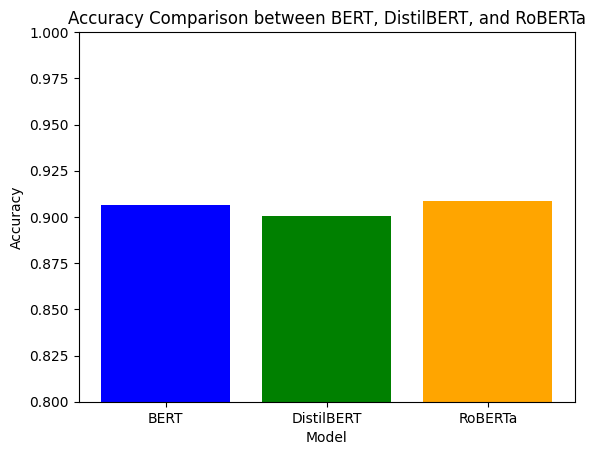

In [202]:
import matplotlib.pyplot as plt

bert_accuracy = 0.9065
distilbert_accuracy = 0.9005
roberta_accuracy = 0.9085

models = ['BERT', 'DistilBERT', 'RoBERTa']
accuracies = [bert_accuracy, distilbert_accuracy, roberta_accuracy]

plt.bar(models, accuracies, color=['blue', 'green', 'orange'])
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Accuracy Comparison between BERT, DistilBERT, and RoBERTa')
plt.ylim(0.8, 1.0)  # Adjust the y-axis limits as needed
plt.show()
